# 1. Business Understanding

## 1.1 Objective
Predict which Tweets are about real disasters and which ones are not.

## 1.2 Description
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:

The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.


[Description from Kaggle's "Real or Not? NLP with Disaster Tweets"](https://www.kaggle.com/c/nlp-getting-started)

# 2. Data Understanding

## 2.1 Import Libraries

First, We need to import necessary python libraries which will be used in this project. 

In [12]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('ggplot')
import re
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
from collections import  Counter
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


## 2.2 Review the data

### 2.2.1 Loading data

In [18]:
tweet = pd.read_csv('D:/kaggle/Real or Not NLP with Disaster Tweets/train.csv')
test = pd.read_csv('D:/kaggle/Real or Not NLP with Disaster Tweets/test.csv')

### 2.2.2 Visualisation and Preprocessing

Checking the distribution of class

Text(0, 0.5, 'tweets')

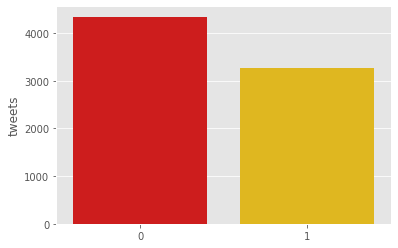

In [17]:
x = tweet.target.value_counts()
sns.barplot(x.index, x, palette='hot')
plt.gca().set_ylabel('tweets')

Number of characters in tweets

Text(0.5, 0.98, 'Characters in tweets')

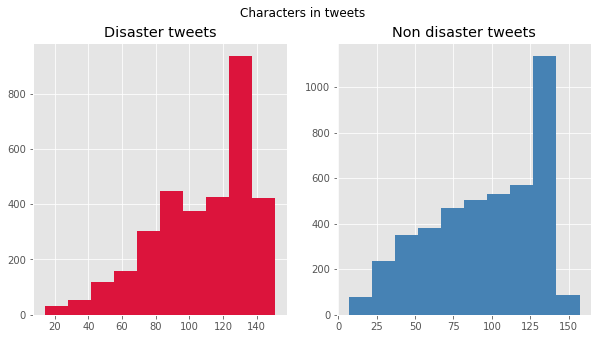

In [20]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='crimson')
ax1.set_title('Disaster tweets')
tweet_len = tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='steelblue')
ax2.set_title('Non disaster tweets')
fig.suptitle('Characters in tweets')

Number of words in a tweet

Text(0.5, 0.98, 'Words in a tweet')

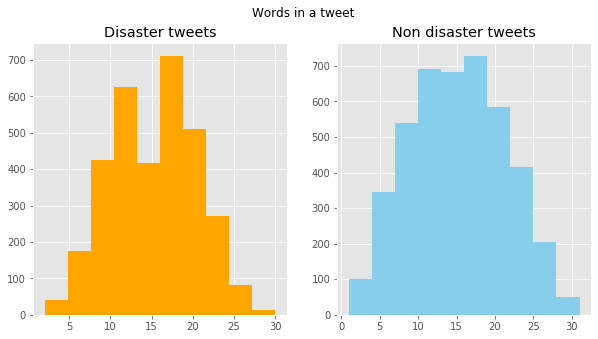

In [21]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, color='orange')
ax1.set_title('Disaster tweets')
tweet_len = tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='skyblue')
ax2.set_title('Non disaster tweets')
fig.suptitle('Words in a tweet')

Text(0.5, 0.98, 'Average word length in each tweet')

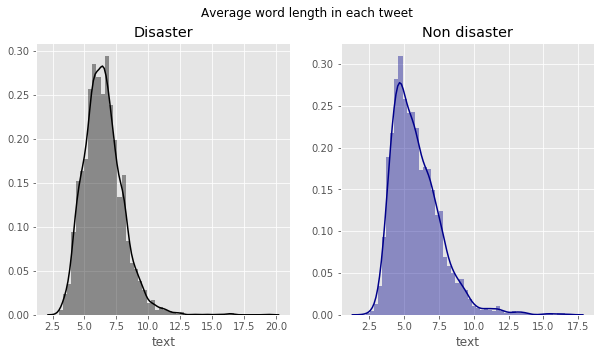

In [23]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word = tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='black')
ax1.set_title('Disaster')
word = tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='darkblue')
ax2.set_title('Non disaster')
fig.suptitle('Average word length in each tweet')

Punctuations in non-disaster class

<BarContainer object of 20 artists>

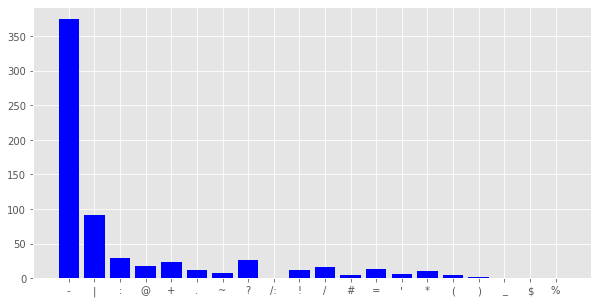

In [25]:
def create_corpus(target):
    corpus=[]
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

def create_corpus_df(tweet, target):
    corpus=[]
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

plt.figure(figsize=(10,5))
corpus = create_corpus(0)
dic = defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
x,y=zip(*dic.items())
plt.bar(x, y,color='blue')

Punctuations in disaster class

<BarContainer object of 18 artists>

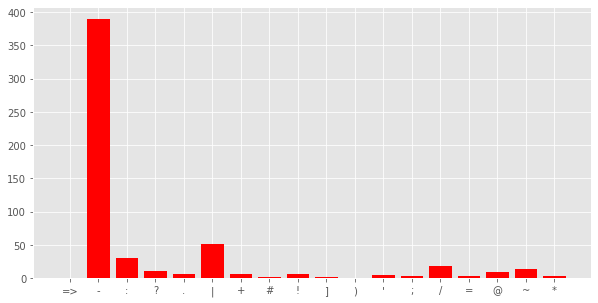

In [26]:
plt.figure(figsize=(10,5))
corpus = create_corpus(1)
dic = defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
x,y = zip(*dic.items())
plt.bar(x, y, color='red')

Common words

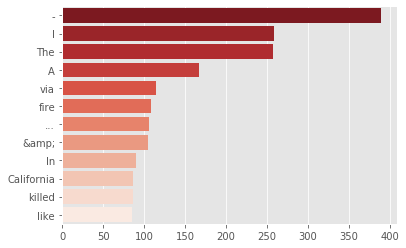

In [30]:
counter = Counter(corpus)
most = counter.most_common()
x=[]
y=[]
for word, count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
sns.barplot(x=y, y=x, palette='Reds_r')

Bigram analysis

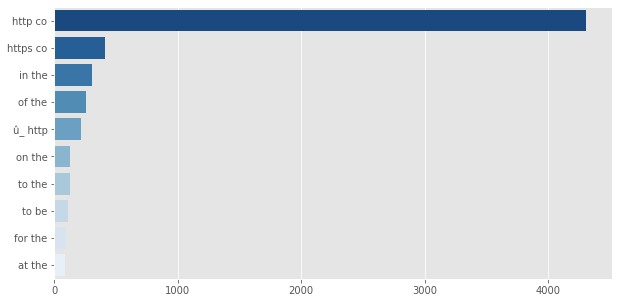

In [32]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
plt.figure(figsize=(10,5))
top_tweet_bigrams = get_top_tweet_bigrams(tweet['text'])[:10]
x,y = map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x, palette='Blues_r')

Renaming location names

In [33]:
df = pd.concat([tweet,test])
df.shape

(10876, 5)

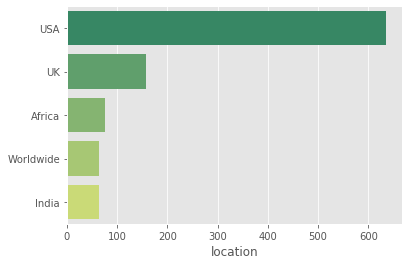

In [40]:
df['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)
sns.barplot(y = df['location'].value_counts()[:5].index, x = df['location'].value_counts()[:5],
            palette='summer', orient='h')

Applying the cleaning function to both test and training datasets

In [41]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
df['text'] = df['text'].apply(lambda x: clean_text(x))
# Let's take a look at the updated text
df['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

Removing Emojis

In [42]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df['text']=df['text'].apply(lambda x: remove_emoji(x))

# 3 Modeling

## 3.1 Setting function

In [44]:
tweet_1 = tweet.text.values
test_1 = test.text.values
sentiments = tweet.target.values

tokenization 

In [46]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(tweet_1)
vocab_length = len(word_tokenizer.word_index) + 1

nltk.download('punkt')

def metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Accuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)
        
longest_train = max(tweet_1, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(embed(tweet_1), length_long_sentence, padding='post')
test_sentences = pad_sequences(
    embed(test_1), 
    length_long_sentence,
    padding='post'
)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lee\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


Global Vectors for Word Representation (GloVe)

In [72]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('D:/kaggle/Real or Not NLP with Disaster Tweets/glove_file/glove.6B.100d.txt',encoding="utf-8")

In [74]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [75]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Splitting dataset

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    padded_sentences, 
    sentiments, 
    test_size=0.25
)

## 3.2 LSTM model

In [79]:
def BLSTM():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix], 
                        input_length=length_long_sentence))
    model.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [78]:
model = BLSTM()
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = [X_test, y_test],
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5709 samples, validate on 1904 samples
Epoch 1/7
5709/5709 [==============================] - 75s 13ms/step - loss: 0.6410 - acc: 0.6781 - val_loss: 0.4766 - val_acc: 0.7831

Epoch 00001: val_loss improved from inf to 0.47661, saving model to model.h5
Epoch 2/7
5709/5709 [==============================] - 59s 10ms/step - loss: 0.5077 - acc: 0.7735 - val_loss: 0.4637 - val_acc: 0.7836

Epoch 00002: val_loss improved from 0.47661 to 0.46367, saving model to model.h5
Epoch 3/7
5709/5709 [==============================] - 60s 11ms/step - loss: 0.4501 - acc: 0.8049 - val_loss: 0.4389 - val_acc: 0.8067

Epoch 00003: val_loss improved from 0.46367 to 0.43890, saving model to model.h5
Epoch 4/7
5709/5709 [==============================] - 64s 11ms/step - loss: 0.4244 - acc:

## 4. Evaluation

## 4.1 visualisation

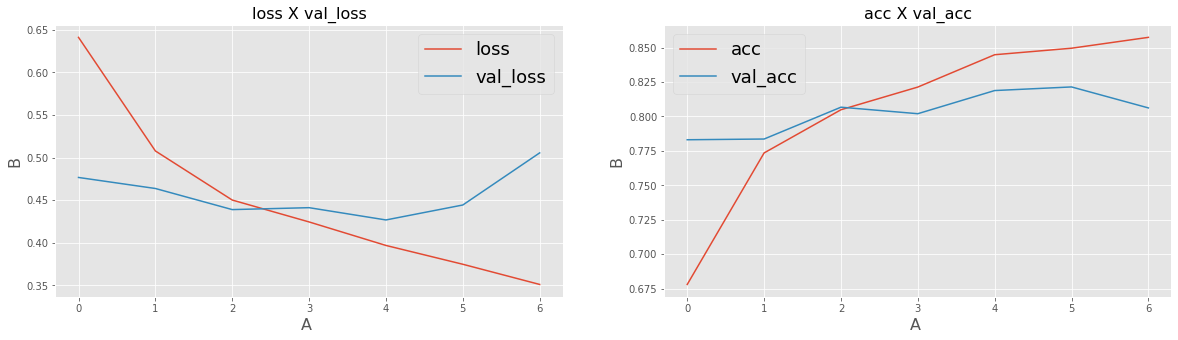

In [90]:
plot(history, [['loss', 'val_loss'],['acc', 'val_acc']])

## 4.2 Confusion matrix

In [91]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

1904/1904 [==============================] - 9s 4ms/step
Loss: 0.5054612420186275
Accuracy: 0.8061974789915967


In [92]:
preds = model.predict_classes(X_test)
metrics(preds, y_test)

F1-score:  0.7706650093225607
Precision:  0.7788944723618091
Recall:  0.7626076260762608
Acuracy:  0.8061974789915967
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1091
           1       0.78      0.76      0.77       813

    accuracy                           0.81      1904
   macro avg       0.80      0.80      0.80      1904
weighted avg       0.81      0.81      0.81      1904



In [93]:
model.load_weights('model.h5')
preds = model.predict_classes(X_test)
metrics(preds, y_test)

F1-score:  0.7657841140529531
Precision:  0.7085427135678392
Recall:  0.8330871491875923
Acuracy:  0.8188025210084033
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1227
           1       0.71      0.83      0.77       677

    accuracy                           0.82      1904
   macro avg       0.80      0.82      0.81      1904
weighted avg       0.83      0.82      0.82      1904



# 5. Submitting

## 5.1 Predicting in test set

Since the 'model.predict_classes' can not be used in 'pd.DataFrame', the value of column 'target' be added after creating dataframe.

In [109]:
submission = pd.DataFrame({'id': test.id, 'target': 0})
submission.target = model.predict_classes(test_sentences)

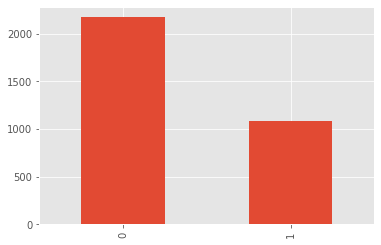

In [110]:
submission.target.value_counts().plot.bar()